In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import make_column_transformer

In [2]:
def kf_RandomFroestRegressor(X, y, n_estimators =100 ,k=5):
    # Set up k-fold parameters
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    #Store the results of each validation
    train_r_squared = []
    test_r_squared = []
    train_mse = []
    test_mse = []
    
    # Creat a new array to store the error of each data point later.
    n_outputs = y.shape[1]
    train_errors = np.empty((0, n_outputs), dtype=float)
    test_error = np.empty((0, n_outputs), dtype=float)

    # Iterate through the cross-validation
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # set up the RF model
        model = RandomForestRegressor(n_estimators = n_estimators, n_jobs=-1).fit(X_train, y_train)
        
        # Predict and calculate performance and errors
        train_pred = model.predict(X_train)
        train_e = y_train - train_pred
        train_errors = np.concatenate((train_errors,train_e), axis = 0 )
        
        train_r_squared.append(r2_score(y_train, train_pred))
        train_mse.append(mean_squared_error(y_train, train_pred))
        
        
        test_pred = model.predict(X_test)
        test_e = y_test - test_pred
        test_error = np.concatenate((test_error,test_e), axis = 0 )
        
        test_r_squared.append(r2_score(y_test, test_pred))
        test_mse.append(mean_squared_error(y_test, test_pred))
        
    print(f"Train: R-squared = {np.mean(train_r_squared)}, MSE = {np.mean(train_mse)}\nTest: R-squared = {np.mean(test_r_squared)}, MSE = {np.mean(test_mse)}")
    return (train_errors, test_error)


In [3]:
pd.read_csv('cleaned_extracted_data.csv')

,SHLT,BMI,MSTOT,COGTOT,INHPFN,INHPE,HHHRES,HCHILD,LIVSIB,HINPOV,HINPOVA,HAIRA,HATOTB,IEARN,HITOT,PENINC,HIGOV,PRPCNT,SLFEMP,RETMON
0,5.0,33.0,14.0,17.0,0.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.000000e+00,20000.000000,22400.000000,0.0,0.0,0.0,0.0,0
1,4.0,23.8,8.0,14.0,0.0,0.0,2.0,6.0,2.0,0.0,0.0,0.0,1.500000e+04,25000.000000,107000.000000,0.0,0.0,1.0,0.0,0
2,2.0,43.0,14.0,23.0,0.0,0.0,3.0,3.0,4.0,0.0,0.0,200000.0,3.240000e+05,0.000000,57024.000000,1.0,1.0,0.0,0.0,1
3,2.0,27.0,13.0,23.0,0.0,0.0,3.0,3.0,4.0,0.0,0.0,8000.0,2.800000e+04,37000.000000,80457.000000,1.0,1.0,0.0,0.0,0
4,2.0,21.6,15.0,29.0,0.0,0.0,2.0,2.0,1.0,0.0,0.0,600000.0,1.171000e+06,15000.000000,46652.000000,1.0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38482,1.0,22.0,11.0,19.0,0.0,0.0,2.0,7.0,2.0,0.0,0.0,0.0,5.238116e+05,10000.000000,85060.000000,0.0,0.0,1.0,0.0,0
38483,3.0,29.2,14.0,25.0,0.0,0.0,2.0,2.0,5.0,0.0,0.0,15000.0,3.600000e+05,45000.000000,165800.000000,0.0,0.0,1.0,0.0,0
38484,3.0,21.3,15.0,25.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,150000.0,1.280900e+06,0.000000,28437.000000,0.0,1.0,0.0,1.0,0
38485,3.0,24.1,15.0,27.0,0.0,0.0,2.0,2.0,2.0,0.0,0.0,8000.0,5.800000e+04,75000.000000,100020.000000,0.0,0.0,1.0,0.0,0


Train: R-squared = 0.9569698170794029, MSE = 0.2833207445307741
Test: R-squared = 0.7042593035057843, MSE = 1.9478185834955994


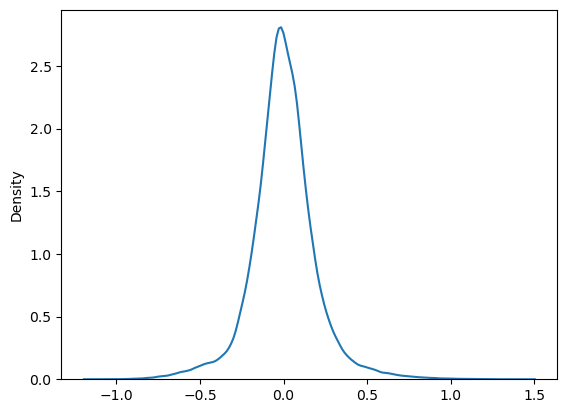

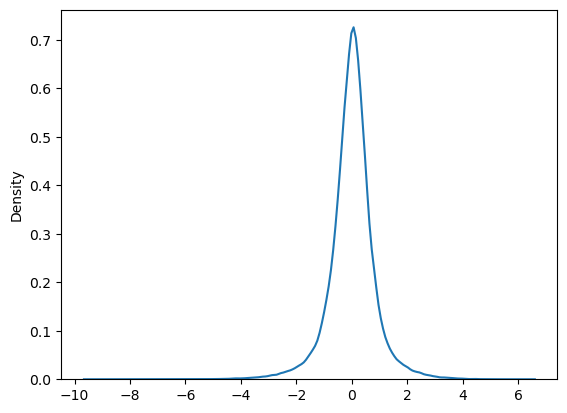

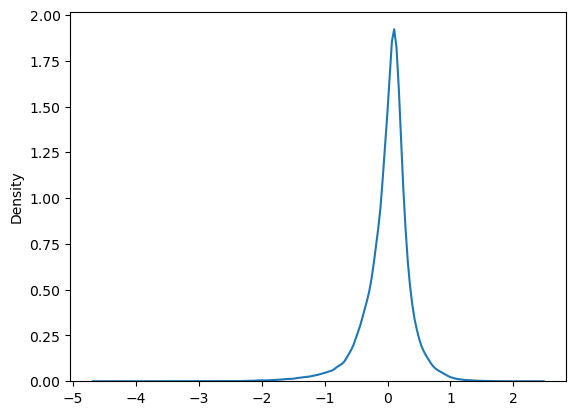

In [4]:
# df = pd.read_csv('cleaned_extracted_data.csv').drop(["HINPOVA","INHPE"], axis = 1)

df = pd.read_csv('Removed_outliers_byGroup_data.csv')

X = df.drop(['SHLT', 'COGTOT', 'MSTOT'], axis=1).values
y = df[['SHLT', 'COGTOT', 'MSTOT']].values

train_e, test_e = kf_RandomFroestRegressor(X,y)
for i in range(3):
    sns.kdeplot(train_e[:,i])
    plt.show()

Run a random forest on raw data

In [5]:

# #Separate the input features and target values
# X = df.drop(['SHLT', 'COGTOT', 'MSTOT','BMI'], axis=1)  # Input features
# y = df[['SHLT', 'COGTOT', 'MSTOT']]  # Target variables
# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# # Initialize a dictionary to store the models and their metrics
# models_metrics = {}

# # Train separate models for each target variable
# for target in y.columns:
#     # Train the model
#     model = RandomForestRegressor(n_estimators = 200, n_jobs=-1)
#     model.fit(X_train, y_train[target])
    
#     # Predict on the testing set
#     y_pred = model.predict(X_test)
    
#     # Evaluate the model
#     r2 = r2_score(y_test[target], y_pred)
#     mse = mean_squared_error(y_test[target], y_pred)
    
#     # Store the model and its metrics
#     models_metrics[target] = {'R2 Score': r2, 'MSE': mse}

# # Display the models' metrics
# for target, metrics in models_metrics.items():
#     print(f"Model for {target}: R2 Score = {metrics['R2 Score']}, MSE = {metrics['MSE']}")

In [6]:
continuous_features = ['BMI', 'INHPFN',  'HHHRES', 'HCHILD','LIVSIB',  'HAIRA', 'HATOTB', 'IEARN','HITOT', 'PRPCNT']
cate_features = ['HINPOV','PENINC', 'HIGOV', 'RETMON', 'SLFEMP']

Run the data on normalized and encoded data or data with polynomial feature

In [7]:
# transfer data
trans = make_column_transformer((StandardScaler(), continuous_features),
                                remainder="passthrough")

df2 = pd.DataFrame( trans.fit_transform( df ) , columns=trans.get_feature_names_out( ) )
df2.columns
target_columns = ['remainder__SHLT', 'remainder__MSTOT','remainder__COGTOT']

Train: R-squared = 0.9568535091864089, MSE = 0.28367072866172893
Test: R-squared = 0.7041579676640876, MSE = 1.9516917465311987


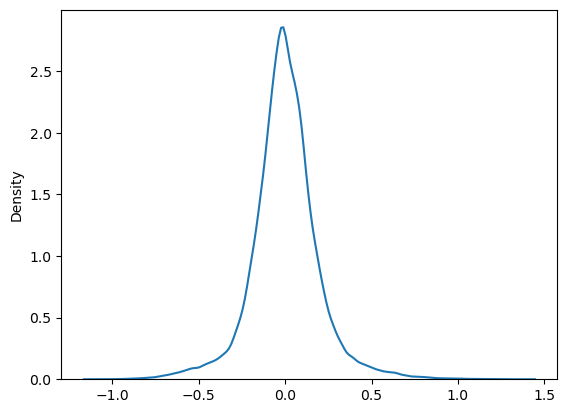

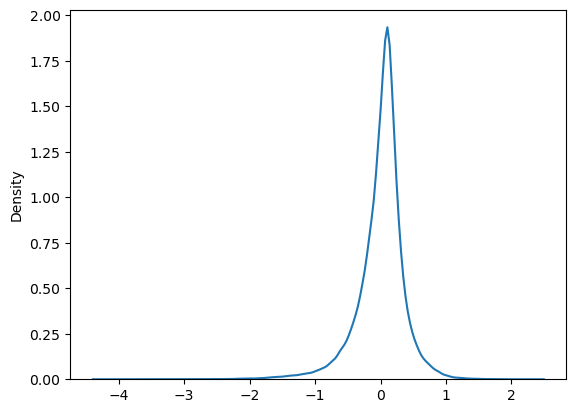

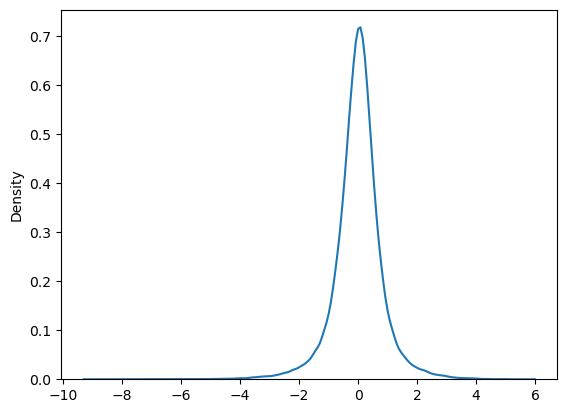

In [8]:
X = df2.drop(target_columns, axis=1).values
y = df2[target_columns].values

train_e, test_e = kf_RandomFroestRegressor(X,y)
for i in range(3):
    sns.kdeplot(train_e[:,i])
    plt.show()

In [9]:
# target_columns = ['remainder__SHLT', 'remainder__MSTOT','remainder__COGTOT']
# X = df2.drop(target_columns, axis=1)  # Input features
# y = df2[target_columns]  # Target variables
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# for target in target_columns:
#     model = RandomForestRegressor(n_estimators = 150, n_jobs=-1)
#     model.fit(X_train, y_train[target])

#         # Predict on the testing set
#     y_pred = model.predict(X_test)

#         # Evaluate the model
#     r2 = r2_score(y_test[target], y_pred)
#     mse = mean_squared_error(y_test[target], y_pred)

#         # Store the model and its metrics
#     print(f"R2 Score: {r2} MSE: {mse}")